In [51]:
import cv2, os, glob
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
import numpy as np
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
from sklearn.cluster import KMeans
from matplotlib.colors import hsv_to_rgb
%matplotlib inline

In [286]:
basepath = '/Users/Janjua/Desktop/Projects/random'
files = [x for x in glob.glob(basepath + "/*.tif")]
print(files)

['/Users/Janjua/Desktop/Projects/random/112_1680.tif', '/Users/Janjua/Desktop/Projects/random/112_1456.tif', '/Users/Janjua/Desktop/Projects/random/1.tif', '/Users/Janjua/Desktop/Projects/random/112_2464.tif', '/Users/Janjua/Desktop/Projects/random/112_1568.tif', '/Users/Janjua/Desktop/Projects/random/112_2688.tif']


(112, 112, 3)


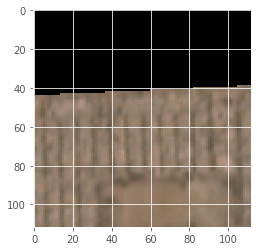

In [106]:
img_file = files[0]
img = cv2.imread(img_file)
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [10]:
flags = [i for i in dir(cv2) if i.startswith('COLOR_')]

572 305
7819 305
(122, 106, 77)
8947 572
(224, 179, 169)


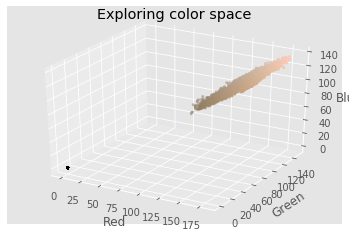

In [42]:
r, g, b = cv2.split(img)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")
pixel_colors = img.reshape((np.shape(img)[0]*np.shape(img)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()
colors_map = [(round(x[0]*225), round(x[1]*225), round(x[2]*225)) for x in pixel_colors]
sum_of_vals = [(x[0]+x[1]+x[2]) for x in colors_map]
print(max(sum_of_vals), min(x for x in sum_of_vals if x > 0))
for ix, val in enumerate(sum_of_vals):
    if val == 572 or val == 305:
        print(ix, val)
        print(colors_map[ix])
axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.title('Exploring color space')
plt.show()

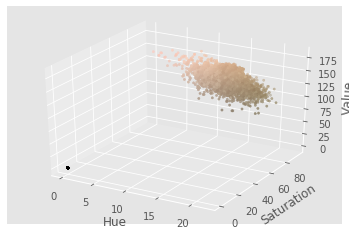

In [49]:
hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv_img)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

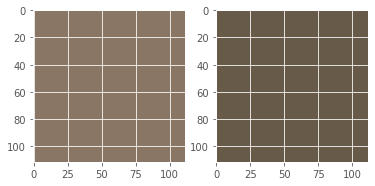

In [133]:
#light_brown = (1, 90, 127)
light_brown = (104, 90, 73)
dark_brown = (138, 118, 100)
lo_square = np.full((112, 112, 3), light_brown, dtype=np.uint8) / 255.0
do_square = np.full((112, 112, 3), dark_brown, dtype=np.uint8) / 255.0
plt.subplot(1, 2, 1)
plt.imshow(do_square)
plt.subplot(1, 2, 2)
plt.imshow(lo_square)
plt.show()

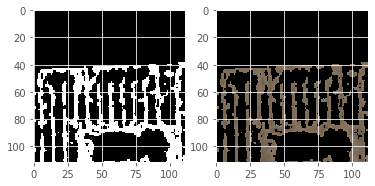

In [134]:
mask = cv2.inRange(img, light_brown, dark_brown)
result = cv2.bitwise_and(img, img, mask=mask)
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()

In [373]:
"""
Base classes and methods used by all kernels
"""

__author__ = 'lejlot'

import numpy as np
from abc import abstractmethod, ABCMeta

class Kernel(object):
    """
    Base, abstract kernel class
    """
    __metaclass__ = ABCMeta

    def __call__(self, data_1, data_2):
        return self._compute(data_1, data_2)

    @abstractmethod
    def _compute(self, data_1, data_2):
        """
        Main method which given two lists data_1 and data_2, with
        N and M elements respectively should return a kernel matrix
        of size N x M where K_{ij} = K(data_1_i, data_2_j)
        """
        raise NotImplementedError('This is an abstract class')

    def gram(self, data):
        """
        Returns a Gramian, kernel matrix of matrix and itself
        """
        return self._compute(data, data)

    @abstractmethod
    def dim(self):
        """
        Returns dimension of the feature space
        """
        raise NotImplementedError('This is an abstract class')

    def __str__(self):
        return self.__class__.__name__

    def __repr__(self):
        return str(self)

    def __add__(self, kernel):
        return KernelSum(self, kernel)

    def __mul__(self, value):
        if isinstance(value, Kernel):
            return KernelProduct(self, value)
        else:
            if isinstance(self, ScaledKernel):
                return ScaledKernel(self._kernel, self._scale * value)
            else:
                return ScaledKernel(self, value)

    def __rmul__(self, value):
        return self.__mul__(value)

    def __div__(self, scale):
        return ScaledKernel(self, 1./scale)

    def __pow__(self, value):
        return KernelPower(self, value)
    
    def get_params(self, deep=True):         
        return dict(kernels=self.kernels)

class KernelSum(Kernel):
    """
    Represents sum of a pair of kernels
    """

    def __init__(self, kernel_1, kernel_2):
        self._kernel_1 = kernel_1
        self._kernel_2 = kernel_2

    def _compute(self, data_1, data_2):
        return self._kernel_1._compute(data_1, data_2) + \
               self._kernel_2._compute(data_1, data_2)

    def dim(self):
        # It is too complex to analyze combined dimensionality, so we give a lower bound
        return max(self._kernel_1.dim(), self._kernel_2.dim())

    def __str__(self):
        return '(' + str(self._kernel_1) + ' + ' + str(self._kernel_2) + ')'


class KernelProduct(Kernel):
    """
    Represents product of a pair of kernels
    """

    def __init__(self, kernel_1, kernel_2):
        self._kernel_1 = kernel_1
        self._kernel_2 = kernel_2

    def _compute(self, data_1, data_2):
        return self._kernel_1._compute(data_1, data_2) * \
               self._kernel_2._compute(data_1, data_2)

    def dim(self):
        # It is too complex to analyze combined dimensionality, so we give a lower bound
        return max(self._kernel_1.dim(), self._kernel_2.dim())

    def __str__(self):
        return '(' + str(self._kernel_1) + ' * ' + str(self._kernel_2) + ')'


class KernelPower(Kernel):
    """
    Represents natural power of a kernel
    """

    def __init__(self, kernel, d):
        self._kernel = kernel
        self._d = d
        if not isinstance(d, int) or d<0:
            raise Exception('Kernel power is only defined for non-negative integer degrees')

    def _compute(self, data_1, data_2):
        return self._kernel._compute(data_1, data_2) ** self._d

    def dim(self):
        # It is too complex to analyze combined dimensionality, so we give a lower bound
        return self._kernel.dim()

    def __str__(self):
        return str(self._kernel) + '^' + str(self._d)


class ScaledKernel(Kernel):
    """
    Represents kernel scaled by a float
    """

    def __init__(self, kernel, scale):
        self._kernel = kernel
        self._scale = scale
        if scale < 0:
            raise Exception('Negation of the kernel is not a kernel!')

    def _compute(self, data_1, data_2):
        return self._scale * self._kernel._compute(data_1, data_2)

    def dim(self):
        return self._kernel.dim()

    def __str__(self):
        if self._scale == 1.0:
            return str(self._kernel)      
        else:
            return str(self._scale) + ' ' + str(self._kernel)


class GraphKernel(Kernel):
    """
    Base, abstract GraphKernel kernel class
    """
    pass

In [388]:
class COLORK(Kernel):
    def _compute(self, data_1, data_2):
        light_brown = (104, 90, 73)
        dark_brown = (138, 118, 100)
        mask = cv2.inRange(data_1, light_brown, dark_brown)
        result = cv2.bitwise_and(data_1, data_1, mask=mask)
        if np.any(data_1 < 0) or np.any(data_2 < 0):
            warnings.warn('MinMax kernel requires data to be strictly positive!')

        minkernel = np.ones((mask.shape[0], mask.shape[0]))
        maxkernel = np.ones((mask.shape[0], mask.shape[0]))
        for d in range(data_1.shape[1]):
            column_1 = mask[:, d].reshape(-1, 1)
            column_2 = mask[:, d].reshape(-1, 1)
            minkernel += np.minimum(column_1, column_2.T) 
            maxkernel += np.maximum(column_1, column_2.T)
        return minkernel/maxkernel

    def dim(self):
        return None

/usr/local/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


Score:  1.0


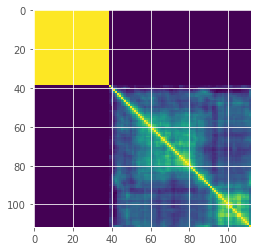

In [402]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
ck = COLORK()
out = ck._compute(img, img)
gpr = GPR()
gpr.fit(out, out)
print("Score: ", gpr.score(out, out))
plt.imshow(out)
plt.show()